<a href="https://colab.research.google.com/github/Aljumaily/COSC5P30/blob/main/cosc5p70_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install graphiq

In [2]:
import math
import numpy as np
from graphiq.circuit.circuit_dag import CircuitDAG
# from graphiq.circuit.ops import Hadamard, CNOT, RZ, Identity, MeasurementCNOTandReset, ClassicalCNOT, SigmaZ
from graphiq.backends.lc_equivalence_check import iso_graph_finder, local_comp_graph, iso_equal_check, is_lc_equivalent
from graphiq.backends.stabilizer.compiler import StabilizerCompiler
from graphiq.state import QuantumState
from graphiq.metrics import CircuitDepth
from graphiq.solvers.time_reversed_solver import TimeReversedSolver
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib
import random
from networkx import Graph

import graphiq.benchmarks.circuits as circ
# matplotlib.rc('font',**{'family':'serif','serif':['CMU Serif']})
# matplotlib.rc('text', usetex=True)


class CircuitOptimizer:
    def __init__(self, e=0, p=3, c=0):
        self.e = e
        self.p = p
        self.c = c
        self.circuit = CircuitDAG(n_emitter=self.e, n_photon=self.p, n_classical=self.c)

    def add(self, gate) -> None:
        self.circuit.add(gate)

    def draw_circuit(self) -> None:
        self.circuit.draw_circuit()

    def draw_graph(self) -> None:
        self.circuit.draw_dag()

    def _get_max_node_index_value(self, raw_edges_with_two_tuples: list) -> int:
        max_value: int = 0
        for i, e in enumerate(raw_edges_with_two_tuples):
            if isinstance(e[0], int) and e[0] > max_value:
                max_value = e[0]
            if isinstance(e[1], int) and e[1] > max_value:
                max_value = e[1]
        return max_value

    # index could either be 0 or 1, as the list of tuple passed contains two coordinates in each tuple.
    def _convert_raw_edges_with_two_tuples_to_list(self, list_of_two_tuples: list, index: int) -> list:
        result: list = []
        for i, e in enumerate(list_of_two_tuples):
            result.append(e[index])
        return result

    def _convert_text_nodes_to_numeric(self, from_edges: list, to_edges: list, current_value: int) -> tuple:
        for i in range(len(from_edges)):
            from_edge_element: any = from_edges[i]
            to_edge_element: any = to_edges[i]
            if isinstance(from_edge_element, str):
                current_value = current_value + 1
                from_edges = [current_value if x==from_edge_element else x for x in from_edges]
                to_edges = [current_value if x==from_edge_element else x for x in to_edges]

            if isinstance(to_edge_element, str):
                current_value = current_value + 1
                from_edges = [current_value if x==to_edge_element else x for x in from_edges]
                to_edges = [current_value if x==to_edge_element else x for x in to_edges]
        from_edges = [x-1 for x in from_edges]
        to_edges = [x-1 for x in to_edges]
        return (from_edges, to_edges)

    def get_graph_edges(self) -> list:
        raw_edges_with_three_tuples: list = self.circuit.dag.edges
        raw_edges_with_two_tuples: list = [tpl[:-1] for tpl in raw_edges_with_three_tuples]

        from_edges: list = self._convert_raw_edges_with_two_tuples_to_list(raw_edges_with_two_tuples, 0)
        to_edges: list = self._convert_raw_edges_with_two_tuples_to_list(raw_edges_with_two_tuples, 1)

        current_value: int = self._get_max_node_index_value(raw_edges_with_two_tuples)

        from_edges_numeric , to_edges_numeric = self._convert_text_nodes_to_numeric(from_edges, to_edges, current_value)
        result: list = list(map(list, zip(from_edges_numeric, to_edges_numeric)))
        return result

    def plot_converted_numeric_graph(self) -> None:
        graph = nx.Graph(self.get_graph_edges())
        pos = nx.kamada_kawai_layout(graph)
        nx.draw_networkx(
            graph, pos,
            edgelist=graph.edges,
            arrows=True,
           with_labels=True,
           arrowstyle='-|>',
           node_color='#afb0fa',
           edgecolors="blue",
           node_size=500,
           alpha=0.8,
           arrowsize=20,
           font_size=10,
           font_color="blue",
           edge_color='red'
        )
        plt.show()


    def get_relabelled_graph(self, original: Graph) -> Graph:
        numbers = list(original.nodes())
        random.shuffle(numbers)
        mapping = dict(zip(original, numbers))
        result: Graph = nx.relabel_nodes(original, mapping, copy=True)
        # print(mapping)
        # print(original.edges)
        # print(result.edges)
        return result

    def get_graph(self) -> Graph:
        return nx.Graph(self.get_graph_edges())

    def get_isomorphic_graphs(self, original:Graph, n: int) -> list[Graph]:
        result: list[Graph] = []
        for i in range(n):
            result.append(self.get_relabelled_graph(original))
        return result


    # Apply the local complementation of each node of g, to get |g| nodes.
    # Now, for each of the |g| found, generate n isomorphic graphs
    # For each pf the isomorphic graphs generated, see if they are lc equivalent.
    # In case they are lc equivalent, add them to a list.
    # That list will be returned later.
    def get_lc_equivalent_graphs(self, n: int) -> list[Graph]:
        g: Graph = self.get_graph()
        num_of_nodes: int = len(g.nodes)
        graphs: list[Graph] = []
        result: list[Graph] = []

        # Apply the local complementation on each node in g.
        for i in range(num_of_nodes):
            graphs.append(local_comp_graph(g, i))

        for i, lcg in enumerate(graphs):
            current_iso_graphs: list = self.get_isomorphic_graphs(lcg, n)
            adj_matrix1 = nx.to_numpy_array(g)
            iso_g2_adj_matrices = [nx.to_numpy_array(graph) for graph in current_iso_graphs]
            for adj_matrix2 in iso_g2_adj_matrices:
                success, solution = is_lc_equivalent(adj_matrix1, adj_matrix2)
                if isinstance(solution, np.ndarray):
                    result.append(nx.to_networkx_graph(adj_matrix2))
        return result
        # local_comp_graph, iso_equal_check

    def get_current_graph_circuit_depth(self) -> int:
        current_graph: Graph = self.get_graph()
        compiler = StabilizerCompiler()
        target = QuantumState(current_graph, rep_type="graph")
        metric = CircuitDepth()
        solver = TimeReversedSolver(
            target=target,
            metric=metric,
            compiler=compiler,
        )
        solver.solve()
        optimal_score, circuit = solver.result
        return optimal_score

    def get_lowest_circuit_depth(self, graphs: list[Graph]) -> int:
        optimal_score: int = self.get_current_graph_circuit_depth()
        print("Initial circuit depth:", optimal_score)
        for graph in graphs:
            compiler = StabilizerCompiler()
            metric = CircuitDepth()

            solver = TimeReversedSolver(
                target=QuantumState(graph, rep_type="graph"),
                metric=metric,
                compiler=compiler,
            )
            solver.solve()
            score, circuit = solver.result
            if score < optimal_score:
                optimal_score = score
                print("New circuit depth:", optimal_score)

        print(f"Best score is {optimal_score}")
        return optimal_score

    # random isomorphic graph generator
    def best_circuit_depth_of_isomorphic_graphs(self, num_of_isomorphic_graphs: int):
        current_graph: Graph = self.get_graph()
        print(
            "There are:", len(current_graph.nodes),
            "nodes in the graph, which means there are", math.factorial(len(current_graph.nodes)),
            "isomorphic graphs.\nOnly", num_of_isomorphic_graphs, "graphs are examined."
        )
        iso_graphs = self.get_isomorphic_graphs(self.get_graph(), num_of_isomorphic_graphs)
        # print(f"{len(iso_graphs)} graphs that are isomorphic to the input.")

        compiler = StabilizerCompiler()
        target = QuantumState(current_graph, rep_type="graph")
        metric = CircuitDepth()
        solver = TimeReversedSolver(
            target=target,
            metric=metric,
            compiler=compiler,
        )
        solver.solve()
        optimal_score, circuit = solver.result

        for graph in iso_graphs:
            solver = TimeReversedSolver(
                target=QuantumState(graph, rep_type="graph"),
                metric=metric,
                compiler=compiler,
            )
            solver.solve()
            score, circuit = solver.result
            if score < optimal_score:
                optimal_score = score
                print(optimal_score, score)

        print(f"Optimal circuit depth is:", optimal_score)

In [3]:
n: int = 2 # Generates two isomorphic graphs
# Note that n=2 will take around 50 seconds to complete execution


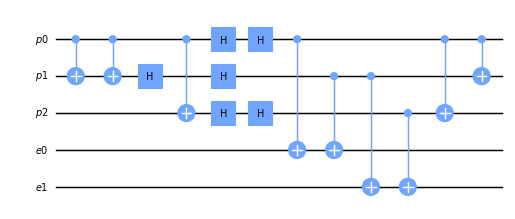

Starting execution...


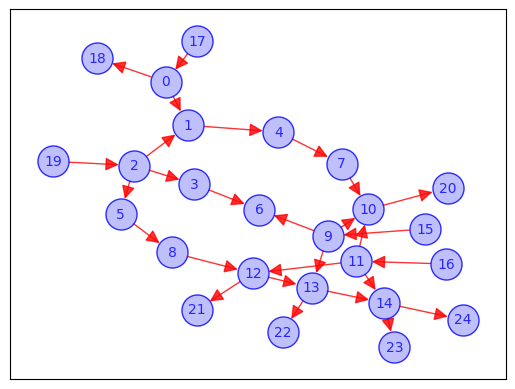

Initial circuit depth: 34
New circuit depth: 33
Best score is 33
The execution has been completed. It took 52.943610191345215 seconds!


In [4]:


#import CircuitOptimizer
import time
from networkx import Graph
from graphiq.circuit.ops import Hadamard, CNOT, Phase

engine: CircuitOptimizer = CircuitOptimizer(e=2, p=3, c=0)

engine.add(CNOT(control=0, control_type="p", target=1, target_type="p"))
engine.add(CNOT(control=0, control_type="p", target=1, target_type="p"))
engine.add(CNOT(control=0, control_type="p", target=2, target_type="p"))

#hadamards
engine.add(Hadamard(register=0, reg_type="p"))
engine.add(Hadamard(register=1, reg_type="p"))
engine.add(Hadamard(register=2, reg_type="p"))
# engine.add(SigmaZ(register=2, reg_type="p"))

# z gate error

#hadamards
engine.add(Hadamard(register=0, reg_type="p"))
engine.add(Hadamard(register=1, reg_type="p"))
engine.add(Hadamard(register=2, reg_type="p"))

#syndrome extraction
# engine.add(ClassicalCNOT(control=1, control_type="p", target=0, target_type="p", c_register=0))
engine.add(CNOT(control=0, control_type="p", target=0, target_type="e"))
engine.add(CNOT(control=1, control_type="p", target=0, target_type="e"))
engine.add(CNOT(control=1, control_type="p", target=1, target_type="e"))
engine.add(CNOT(control=2, control_type="p", target=1, target_type="e"))

# # engine.add(CNOT(control=0, control_type="p", target=3, target_type="p"))
# engine.add(
#     MeasurementCNOTandReset(
#         control=0, control_type="e", target=1, target_type="p", c_register=0
#     )
# )

engine.add(CNOT(control=0, control_type="p", target=2, target_type="p"))
engine.add(CNOT(control=0, control_type="p", target=1, target_type="p"))


engine.draw_circuit()
engine.get_graph_edges()
print("Starting execution...")
engine.plot_converted_numeric_graph()
start = time.time()
# engine.relabel_graph(engine.get_graph())
# engine.best_circuit_depth_of_isomorphic_graphs(100)
eq_lc_graphs: list[Graph] = engine.get_lc_equivalent_graphs(n)
engine.get_lowest_circuit_depth(eq_lc_graphs)
end = time.time()
length = end - start
print("The execution has been completed. It took", length, "seconds!")
#100+300+3000+30000+10000+1000


